In [131]:
import sys
import os
import h5py
import mattplotlib
import pickle

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = './Mdata/'
dirname = './Monocular/' # Working directory 

import numpy as np
import scipy.io as sio
import pickle
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt
import mattplotlib as m
import mattrics as met

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from importlib import reload
from time import time
import dill # more comprehensive pickle

from NTdatasets.generic import GenericDataset
from NTdatasets.cumming.binocular import binocular_single

device = torch.device("cuda:1")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)

# Lazy stuff
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

%load_ext autoreload
%autoreload 2

Running on Computer: [beast]
Save_dir = ./Monocular/
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading expt04
  Time embedding...
11 cells, 362504 time steps.


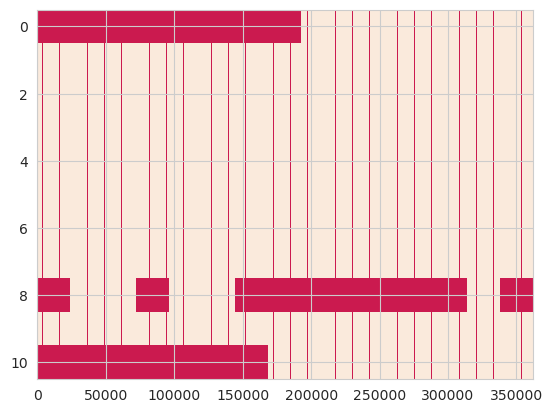

In [132]:
# Load Data
num_lags = 10
expts = ['expt04']
# this can handle multiple experiments
#expts = ['expt04', 'expt05']

from NTdatasets.cumming.monocular import MultiDataset
data = MultiDataset(
    datadir=datadir, filenames=expts, include_MUs=False,
    time_embed=True, num_lags=num_lags )
imagesc(data.dfs.detach().numpy())
print("%d cells, %d time steps."%(data.NC, data.NT))

||## CNIM

In [77]:
num_subs = 8
fw = 21
XTreg0 = 0.01
L1reg0 = 0.0001
Greg = 0.001
Creg = 0.01
# subunit layer
csub_par = ConvLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=num_subs,
    norm_type=1,
    num_inh=num_subs//2, # this specifies that the first half of the subunits should be inhibitory (use "flipped" ReLU nonlinearity)
    filter_dims=fw, # dimensions of the Convolutional filter
    window='hamming', # apply a Hamming window to the filters to avoid edge artifacts 
    NLtype='relu',
    bias=False,
    initialize_center = True)
csub_par['reg_vals'] = {'d2xt': XTreg0, 'l1':L1reg0, 'center':Creg, 'bcs':{'d2xt':1}  }

# 'readout' layer
readout_par = NDNLayer.layer_dict(
    num_filters=data.NC,
    norm_type=0,
    NLtype='softplus',
    bias=True, # b/c it is the last layer
    pos_constraint=True, # this removes negative values created from the inhibitory subunits from the output
    initialize_center = True)

readout_par['reg_vals'] = {'glocalx': Greg  }
cnim_all = NDN.NDN( layer_list=[csub_par, readout_par] )
cnim_all.list_parameters()
#m.draw_model(cnim_all)

Network 0:
  Layer 0:
      weight: torch.Size([210, 8])
  Layer 1:
      weight: torch.Size([288, 11])
      bias: torch.Size([11])


In [78]:
# jump right to shared models
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=2000, num_workers=0,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay = 0.1)
adam_pars['device'] = device

In [79]:
# create DataLoaders
torch.cuda.empty_cache()

data.set_cells()
train_ds = GenericDataset(data[data.train_inds], device=device)
val_ds = GenericDataset(data[data.val_inds], device=device)

  Reset cells_out to full dataset (11 cells).


In [155]:
#cnim_all.fit_dl(train_ds, val_ds, **adam_pars, verbose=2)
#LLs1 = cnim_all.eval_models(val_ds, null_adjusted=True)
#print(np.mean(LLs1))
#
#with open('cnim1.pickle', 'wb') as f:
#    pickle.dump(cnim_all, f)

with open('cnim1.pickle', 'rb') as f:
    cnim_all = pickle.load(f)
input_dims = np.array(data.stim_dims)
input_dims = np.expand_dims(input_dims, 0)

array([[ 1, 36,  1, 10]])

In [164]:
data.stim.shape

torch.Size([362504, 360])

torch.Size([1, 360]) --> torch.Size([1, 288])
torch.Size([1, 288]) --> torch.Size([1, 11])
2 2


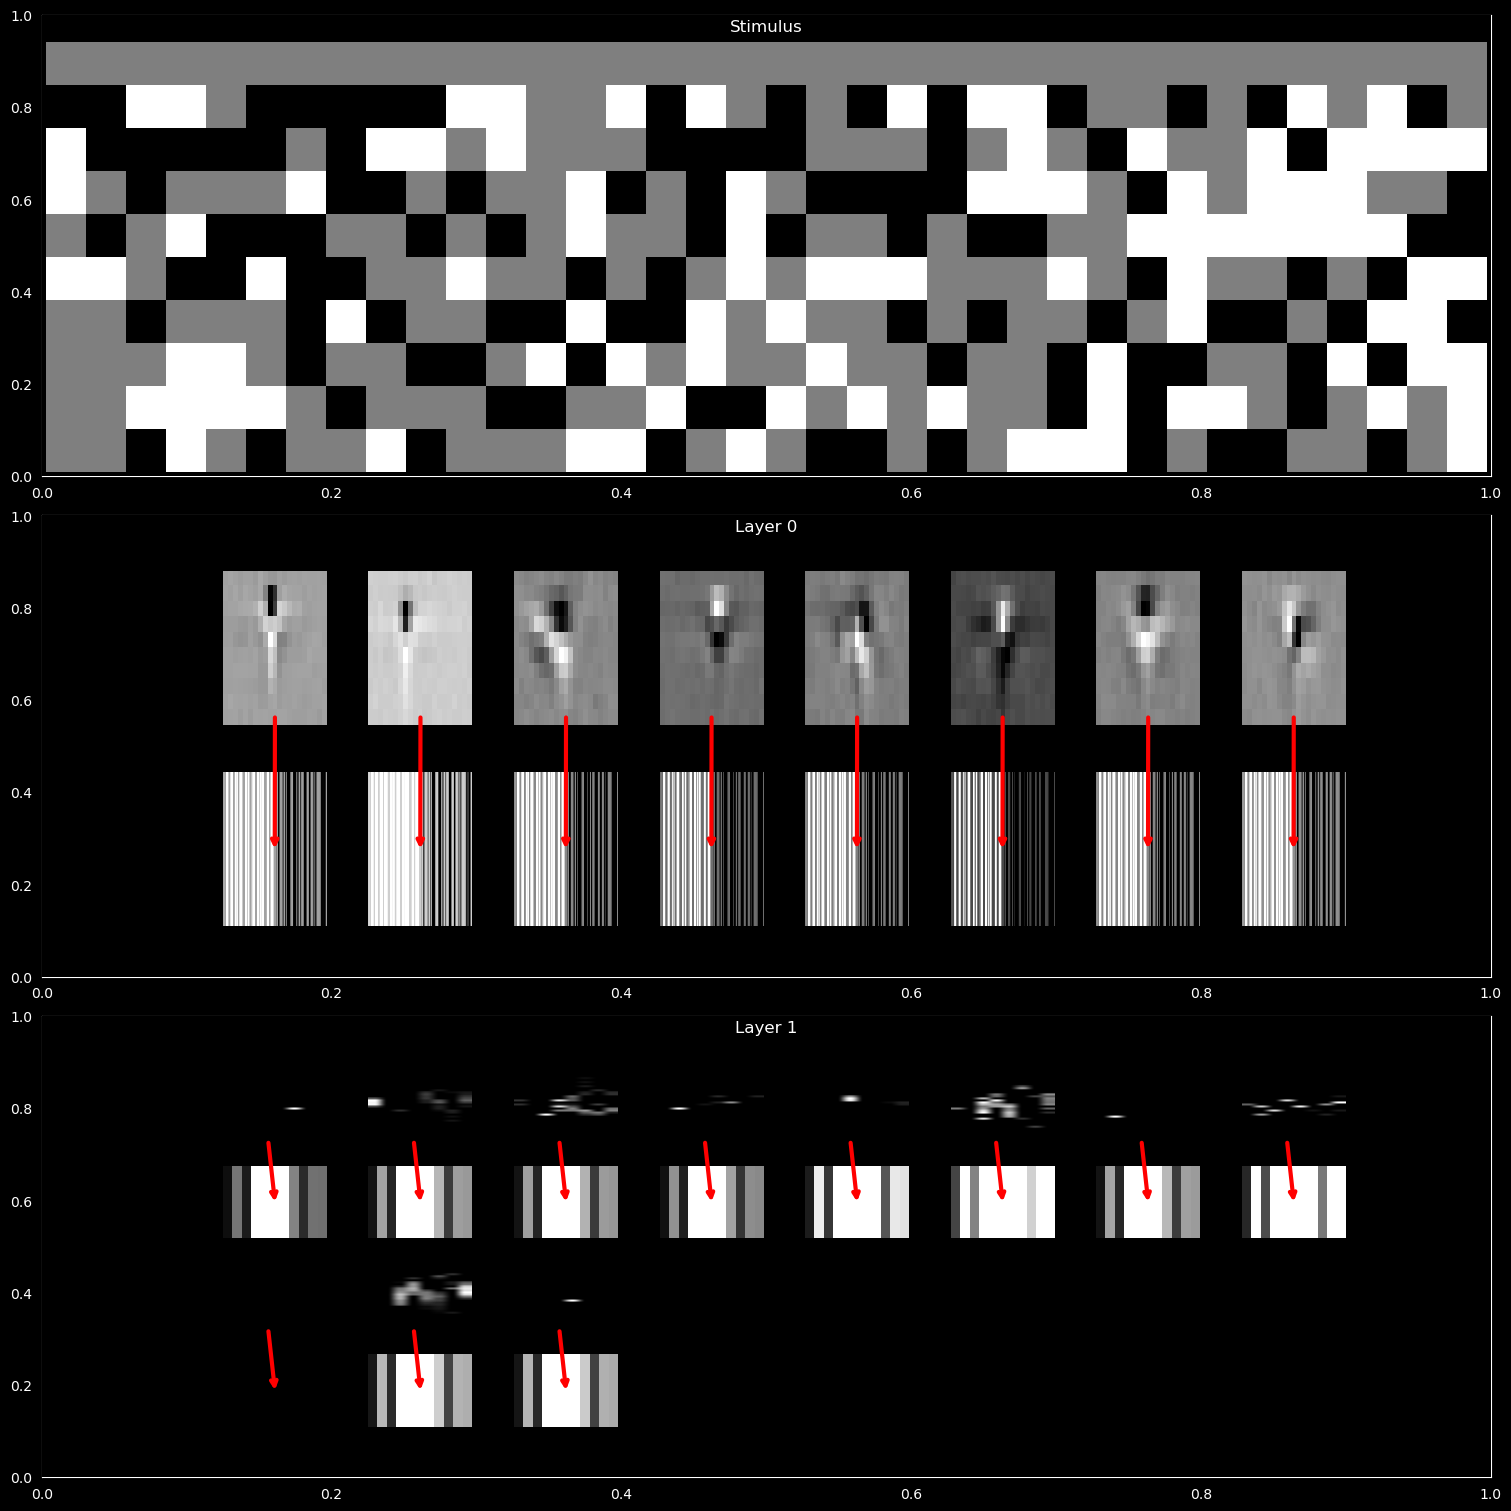

In [162]:
reload(m)
m.darkmode()
m.simulate_network(data.stim[0], data.stim_dims, cnim_all, figsize=(15,15), verbose=True)

(21, 10, 8) (8, 36, 11)


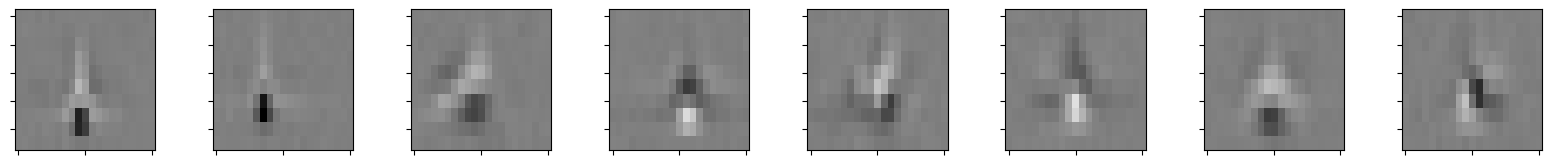

In [94]:
# print shapes
print(cnim_all.networks[0].layers[0].get_weights().shape, cnim_all.networks[0].layers[1].get_weights().shape)
# plot convolutional filters
cnim_all.plot_filters()

/tmp/ipykernel_97309/2559703215.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 6, cc+1)


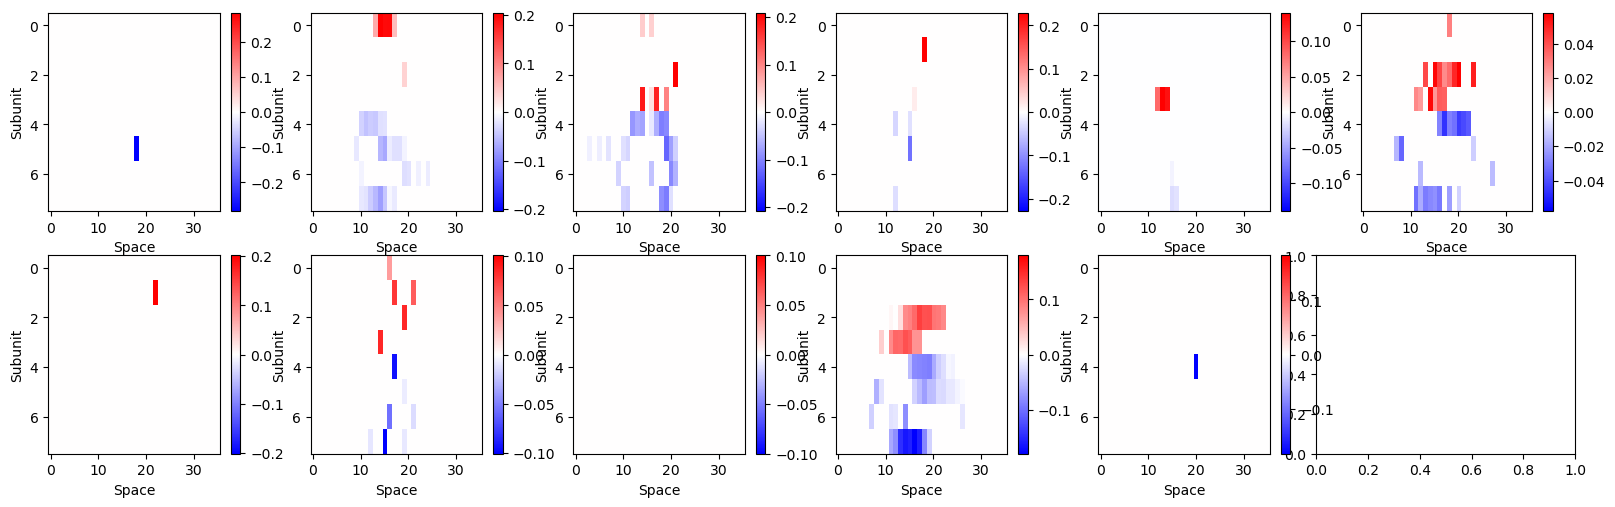

In [95]:
# Readout layer
wR = cnim_all.get_weights(layer_target=1)
wR.shape
# Make inhibitory weights less than zero
wR[num_subs//2:, :] *= -1
num_col = data.NC
ss(2, num_col//2)
for cc in range(num_col):
    plt.subplot(2, 6, cc+1)
    imagesc(wR[:,:,cc].T, cmap='bwr')
    plt.ylabel('Subunit')
    plt.xlabel('Space')
    plt.colorbar()
plt.show()

In [96]:
# https://theaisummer.com/receptive-field/
# https://distill.pub/2019/computing-receptive-fields/
# Article for how to calculate the receptive field of a CNN

# sum over the filters horizontally,
# so that we have 10 x 36 coming out of the first layer
# and 

# get the convolutional filters
hidden = cnim_all.networks[0].layers[0].get_weights()
output = cnim_all.networks[0].layers[1].get_weights()
data.stim_dims, '-->', hidden.shape, '-->', output.shape

([1, 36, 1, 10], '-->', (21, 10, 8), '-->', (8, 36, 11))

In [97]:
np.sum(output, axis=0).shape

(36, 11)

In [98]:
# hidden layer reshaped to be a list of 8 boxes
# (21, 10, 8) --> (8, 10, 21)
hidden_boxes = np.swapaxes(hidden, 0,2)
# means of the weights of each neuron
# (8, 38, 11) --> (36, 11) --> (1, 36, 11)
output_sums = np.expand_dims(np.sum(output, axis=0), 1)
output_sums = np.swapaxes(output_sums, 0,2)

print(output.shape, hidden_boxes.shape, output_sums.shape)

output[:,0,0][output[:,0,0]<0]

print(output.shape)

(8, 36, 11) (8, 10, 21) (11, 1, 36)
(8, 36, 11)


In [99]:
# cool plotting here to make sure it makes sense


# create weights
col_idx = 1680 # terrible hack
weights = {}
# create the edge dictionary per neuron
for c in range(output.shape[2]): # for each neuron
    for col in range(output.shape[1]): # for each column in the neuron
        i = 0 # start the id
        weights[col_idx] = {}
        #print(col_idx)
        # normalize output
        max_weight = np.max(output[:,col,c])
        if max_weight == 0:
                max_weight = 1
        posnorm = output[:,col,c] / max_weight
        # there is no negative value b/c we put pos constraint, need to more automagically account for this
        #negnorm = np.where(output[:,col,c]<0, output[:,col,c], 0) / np.abs(np.min(output[:,col,c][output[:,col,c]<0]))
        output_normalized = posnorm
        #print(output_normalized.shape, np.min(output_normalized), np.max(output_normalized))
        for b, w in enumerate(output_normalized): # for each box & its weight
            for row in range(hidden_boxes[b,:,:].shape[0]): # for each row in the box
                for row in range(hidden_boxes[b,:,:].shape[1]): # for each col in that row
                    weights[col_idx][i] = w
                    i += 1
        col_idx += 1
                
#print(weights.keys())
print(np.sum(hidden_boxes), np.sum(output_sums))

-16.081978 10.891703


In [100]:
# normalize the data we are giving the plot
# preserve dimensionality
# https://stackoverflow.com/questions/29046162/numpy-array-loss-of-dimension-when-masking
posnorm = np.where(hidden_boxes>=0, hidden_boxes, 0) / np.max(hidden_boxes[hidden_boxes>=0])
negnorm = np.where(hidden_boxes<0, hidden_boxes, 0) / np.abs(np.min(hidden_boxes[hidden_boxes<0]))
hidden_boxes_normalized = posnorm + negnorm

print(np.min(hidden_boxes_normalized), np.max(hidden_boxes_normalized))
print(hidden_boxes_normalized.shape, output_sums.shape)

-1.0 1.0
(8, 10, 21) (11, 1, 36)


In [107]:
from IPython.display import display, Javascript, HTML
import json

def draw_grids(data, edges, width, layer_heights, layer_dims, padding, layer_padding):
    display(Javascript("""
        (function(element){
            require(['grids'], function(grids) {
                grids(element.get(0), %s, %s, %d, %s, %s, %d, %d);
            });
        })(element);
    """ % (json.dumps(data), edges, width, layer_heights, layer_dims, padding, layer_padding)))

In [120]:
#display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v5.min'}});"))
#display(Javascript(filename="grids.js"))
#display(HTML(filename="grids.css.html"))
# the layers to display
#layers = [hidden_boxes_normalized.tolist(), output_sums.tolist()]
#draw_grids(layers,
#           weights,
#           width=800,
#           layer_heights={0:200, 1:200},
#           layer_dims={0:{'rows':2, 'cols':4}, 1:{'rows':4, 'cols':3}},
#           padding=5,
#           layer_padding=10)

## excitation/inhibition

(8, 36, 11)


/tmp/ipykernel_97309/4281550828.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 6, cc+1)


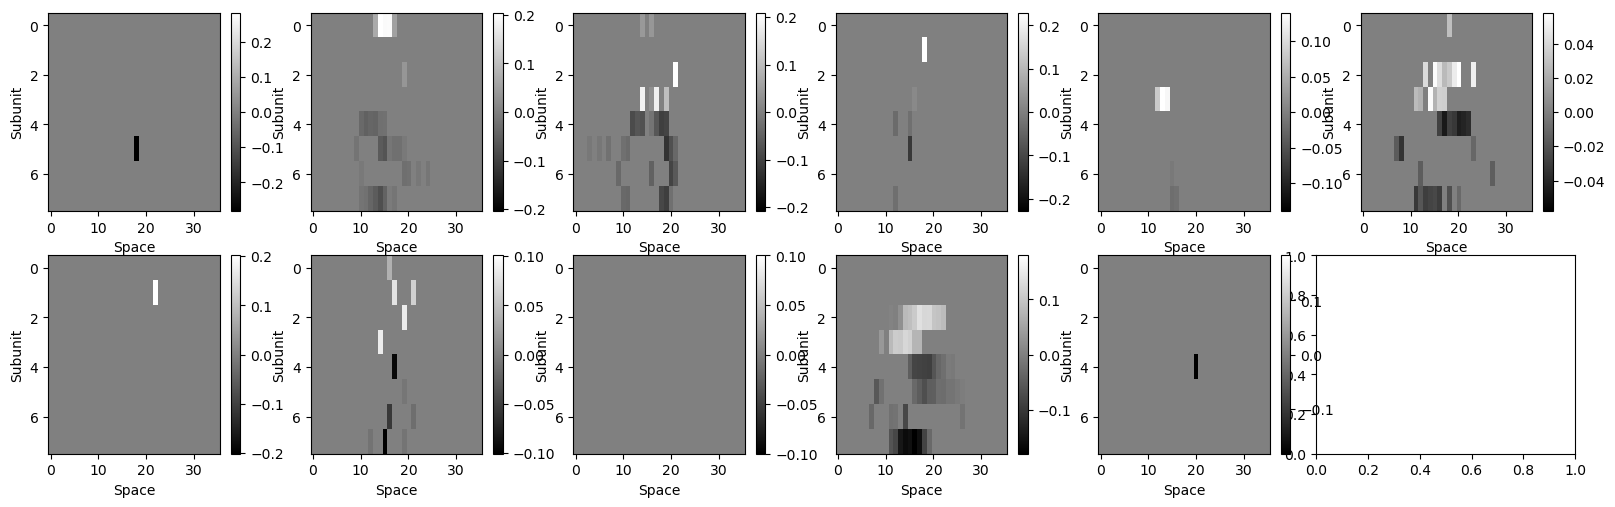

In [121]:
# Readout layer
wR = cnim_all.get_weights(layer_target=1)
print(wR.shape)
wR[num_subs//2:, :] *= -1 # Make inhibitory weights less than zero
num_col = data.NC
ss(2, num_col//2)
for cc in range(num_col):
    plt.subplot(2, 6, cc+1)
    imagesc(wR[:,:,cc].T, cmap='gray')
    plt.ylabel('Subunit')
    plt.xlabel('Space')
    plt.colorbar()
plt.show()

In [122]:
def print_layers(layers):
    for i, layer in enumerate(layers):
        if i < len(layers)-1: # print with trailing arrow if it is not the last one
            print(layer.shape, end=" --> ")
        else: # print without trailing arrow
            print(layer.shape)

def get_layers(model):
    layers = []
    for n in range(len(model.networks)): # iterate over networks
        for l in range(len(model.networks[n].layers)): # iterate over layers for that network
            layers.append(model.networks[n].layers[l].get_weights())
    return layers

# test get_layers(model)
layers = get_layers(cnim_all)
print_layers(layers)

def make_layers(model):
    output = []
    output_normalized = []
    
    # get the layers from the model
    layers = get_layers(model)
    print_layers(layers)
    
    # for the 1D CNN we are using
    # first layer is (width, height, num)
    output.append(np.swapaxes(layers[0], 0,2))
    
    # further layers are (back_weights, width, num)
    for layer in layers[1:]:
        layer_sums = np.expand_dims(np.sum(layer, axis=0), 1)
        layer_sums = np.swapaxes(layer_sums, 0,2)
        output.append(layer_sums)
    
    # normalize the layers to make them between -1 and 1
    for layer in output:
        posnorm = np.where(layer>=0, layer, 0) / np.max(layer[layer>=0])
        if len(layer[layer<0]) > 0: # if there are negative weights, sum them as well
            negnorm = np.where(layer<0, layer, 0) / np.abs(np.min(layer[layer<0]))
            layer_normalized = posnorm + negnorm
        else: # don't worry about negative weights
            layer_normalized = posnorm
        output_normalized.append(layer_normalized)
    
    return output_normalized

print_layers(make_layers(cnim_all))

(21, 10, 8) --> (8, 36, 11)
(21, 10, 8) --> (8, 36, 11)
(8, 10, 21) --> (11, 1, 36)


In [130]:
def make_weights(model):
    # TODO: need to fix this in general
    # TODO: need to take into account scaffold layers vs. regular layers
    
    layers = get_layers(model)
    view_layers = make_layers(model)
    weights = {}
    subunit_idx = len(layers[0].flatten()) # start at layer 1
    weight_idx = 0 # start at the beginning
    for l, layer in enumerate(layers[1:]): # go through the layers, starting from the second one
        l += 1
        view_layer = view_layers[l-1]
        print(l, view_layer.shape)
        for sub in range(layer.shape[2]): # for each subunit
            col_idx = subunit_idx # start the col_idx for this subunit
            for col in range(layer.shape[1]): # for each column in the subunit
                #print(l, weight_idx, subunit_idx, col_idx, layer.shape)
                i = weight_idx # start the id
                weights[col_idx] = {}
                # normalize output
                max_weight = np.max(layer[:,col,sub])
                if max_weight == 0:
                    max_weight = 1
                posnorm = layer[:,col,sub] / max_weight
                layer_normalized = posnorm
                print(layer_normalized.shape)
                # there is no negative value b/c we put pos constraint, need to more automagically account for this
                #negnorm = np.where(output[:,col,c]<0, output[:,col,c], 0) / np.abs(np.min(output[:,col,c][output[:,col,c]<0]))
                #print(layer_normalized.shape, np.min(layer_normalized), np.max(layer_normalized))
                for b, w in enumerate(layer_normalized): # for each box & its weight
                    for row in range(view_layer[b,:,:].shape[0]): # for each row in the box
                        for column in range(view_layer[b,:,:].shape[1]): # for each col in that row
                            weights[col_idx][i] = w
                            i += 1
                col_idx += 1
            subunit_idx += layer.shape[1] # increment the subunit we are at
        weight_idx += len(view_layers[l-1].flatten())
        
    return weights

# test it
layers = [layer.tolist() for layer in make_layers(cnim_all)]
weights = make_weights(cnim_all)

(21, 10, 8) --> (8, 36, 11)
(21, 10, 8) --> (8, 36, 11)
1 (8, 10, 21)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)


In [128]:
from IPython.display import display, Javascript, HTML
import json

def draw_grids(data, edges, width, layer_heights, layer_dims, padding, layer_padding):
    display(Javascript("""
        (function(element){
            require(['grids'], function(grids) {
                grids(element.get(0), %s, %s, %d, %s, %s, %d, %d);
            });
        })(element);
    """ % (json.dumps(data), edges, width, layer_heights, layer_dims, padding, layer_padding)))

In [129]:
display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v5.min'}});"))
display(Javascript(filename="grids.js"))
display(HTML(filename="grids.css.html"))
# the layers to display
draw_grids(layers,
           weights,
           width=800,
           layer_heights={0:200, 1:200},
           layer_dims={0:{'rows':2, 'cols':4}, 1:{'rows':4, 'cols':3}},
           padding=5,
           layer_padding=10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>